In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from numba import njit
from sympy import factor, symbols, lambdify, simplify, expand, collect, Function, nsolve
rcParams['text.usetex'] = True
rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amsfonts}"
%config InlineBackend.figure_format = 'retina'

## Power series solution to $f(x)=-\alpha f(f(x/\alpha))$

In [11]:
x, a1, a2, a3, a4, a5, a6, a7, a8, alpha = symbols("x, a1, a2, a3, a4, a5, a6, a7, a8, alpha")
def f(x):  return 1 + a1*x**2 +  a2*x**4 + a3*x**6 + a4*x**8 + a5*x**10 + a6*x**12
collected_expr = collect(expand(alpha*f(f(x/alpha))+f(x)),x)

In [12]:
equations = []
for i in [0, 2, 4, 6, 8, 10, 12]:
    equations.append(collected_expr.coeff(x,i))
tuple(equations)

(a1*alpha + a2*alpha + a3*alpha + a4*alpha + a5*alpha + a6*alpha + alpha + 1,
 2*a1**2/alpha + 4*a1*a2/alpha + 6*a1*a3/alpha + 8*a1*a4/alpha + 10*a1*a5/alpha + 12*a1*a6/alpha + a1,
 a1**3/alpha**3 + 6*a1**2*a2/alpha**3 + 15*a1**2*a3/alpha**3 + 28*a1**2*a4/alpha**3 + 45*a1**2*a5/alpha**3 + 66*a1**2*a6/alpha**3 + 2*a1*a2/alpha**3 + 4*a2**2/alpha**3 + 6*a2*a3/alpha**3 + 8*a2*a4/alpha**3 + 10*a2*a5/alpha**3 + 12*a2*a6/alpha**3 + a2,
 4*a1**3*a2/alpha**5 + 20*a1**3*a3/alpha**5 + 56*a1**3*a4/alpha**5 + 120*a1**3*a5/alpha**5 + 220*a1**3*a6/alpha**5 + 2*a1**2*a2/alpha**5 + 12*a1*a2**2/alpha**5 + 30*a1*a2*a3/alpha**5 + 56*a1*a2*a4/alpha**5 + 90*a1*a2*a5/alpha**5 + 132*a1*a2*a6/alpha**5 + 2*a1*a3/alpha**5 + 4*a2*a3/alpha**5 + 6*a3**2/alpha**5 + 8*a3*a4/alpha**5 + 10*a3*a5/alpha**5 + 12*a3*a6/alpha**5 + a3,
 a1**4*a2/alpha**7 + 15*a1**4*a3/alpha**7 + 70*a1**4*a4/alpha**7 + 210*a1**4*a5/alpha**7 + 495*a1**4*a6/alpha**7 + 12*a1**2*a2**2/alpha**7 + 60*a1**2*a2*a3/alpha**7 + 168*a1**2*a2*a4/alpha**7 

Power series coefficients and $\alpha$ calculation:

In [13]:
nsolve(tuple(equations), (a1, a2, a3, a4, a5, a6, alpha), (-1.5, 0.1, 0.1, 0.1, 0.1, 0.1, 2.5), prec=25)

Matrix([
[     -1.52762387942695522768231],
[    0.1047869017742089579508788],
[   0.02673273714156627488034822],
[  -0.00354507127776408373106019],
[0.00009069133852570648880921069],
[0.00002166627387787047810992679],
[     2.502897390457998133502086]])

## Recursive calculation of $g(x)$

Coefficients and $\alpha$ from [Feigenbaum, M.J. The universal metric properties of nonlinear transformations. J Stat Phys 21, 669–706 (1979)](https://link.springer.com/article/10.1007/BF01107909).

In [15]:
alpha = 2.5029078750958928
n_recursion = 15

@njit
def g(x):
    """ Recursive calculation of g """
    if np.abs(x)<=1:
        return 1 - 1.527632997*x**2 + 1.048151943E-1*x**4 + 2.670567349E-2*x**6
    else:
        return -alpha*g(g(x/alpha))

@njit
def g_n(x, n):
    """ Recursive calculation of g with max recursion level set to n_recursion """
    if n <= n_recursion:
        if np.abs(x)<=1:
            return 1 - 1.527632997*x**2 + 1.048151943E-1*x**4 + 2.670567349E-2*x**6
        else:
            return -alpha*g_n(g_n(x/alpha, n+1), n+2)
    else:
        return np.nan

## 2D

In [16]:
@njit
def g_on_grid(ax=10, ay=10, nx=100, ny=100):
    z = np.linspace(-ax, ax, nx) + 1.j*np.linspace(-ay, ay, ny)[:,np.newaxis]
    ret = np.zeros(z.shape, dtype = np.complex64)
    z_ = z.ravel()
    ret_ = ret.ravel()
    for i, val in enumerate(z_):
        ret_[i] = g_n(val,0)
    return ret

In [17]:
feigenbaum = g_on_grid(20,18,3000,2400)

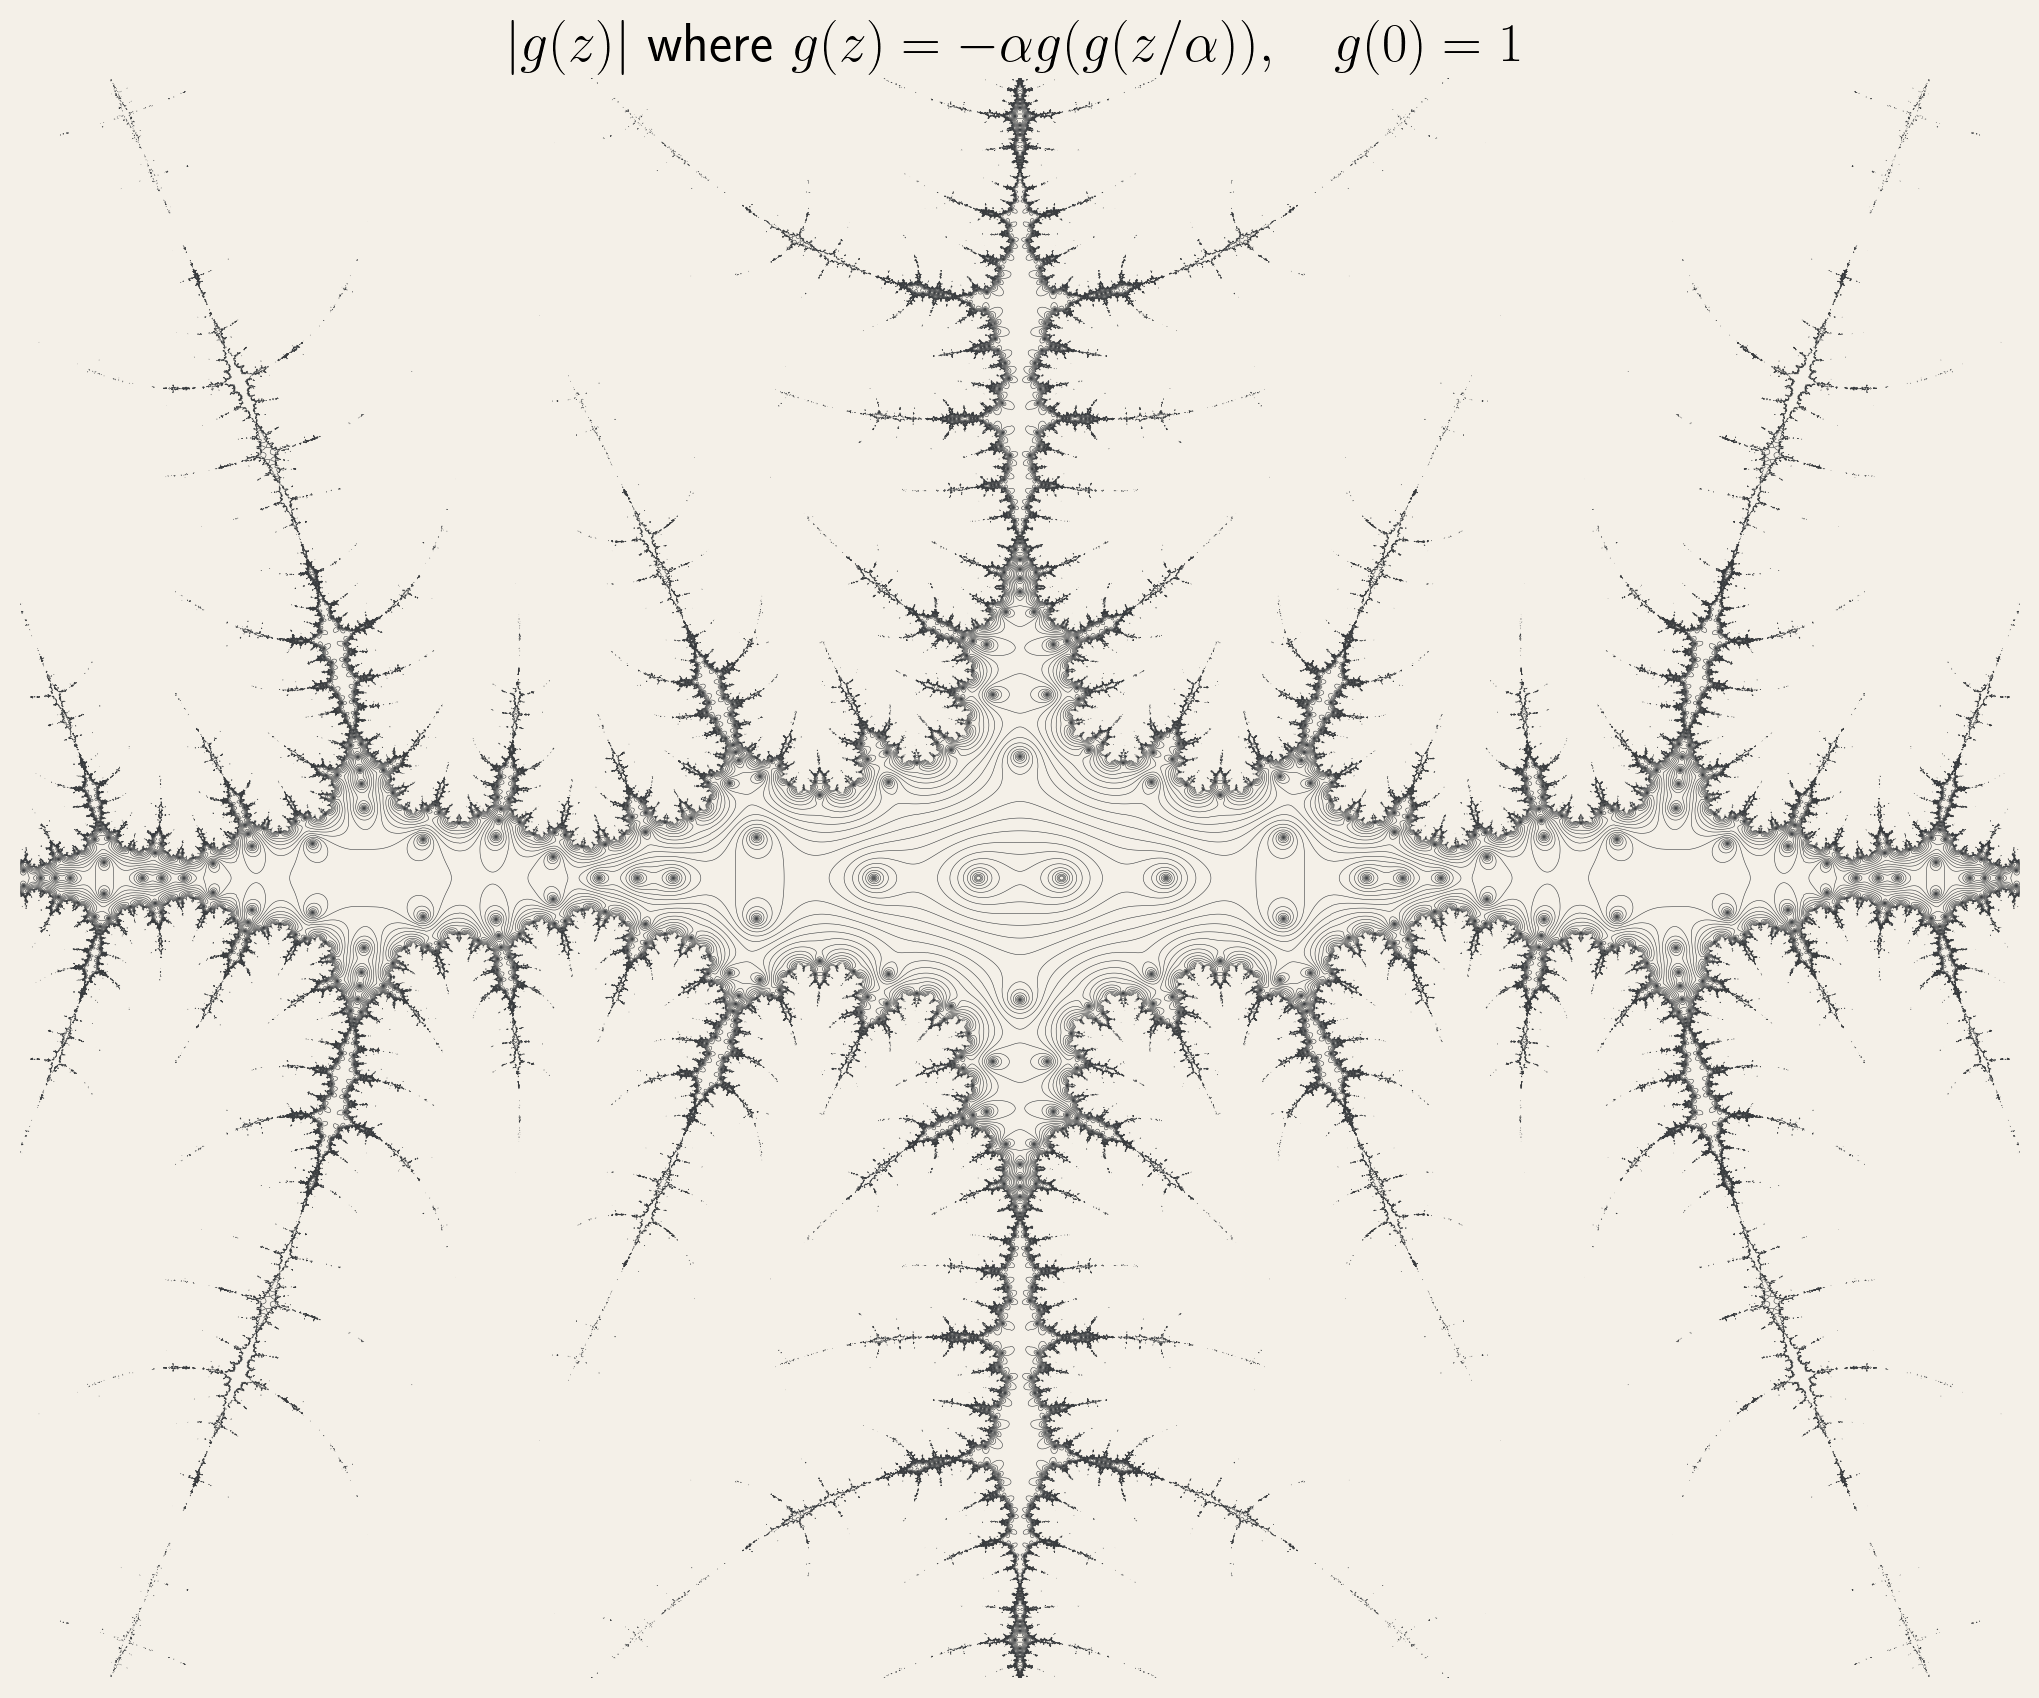

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
fig.set_facecolor("#f4f0e8")
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.contour(np.abs(feigenbaum), colors="#383b3e", levels=np.geomspace(0.1, 1600., 30), linewidths=0.2)
ax.set_aspect('equal', 'box')
ax.set_axis_off()
ax.set_title(r"$|g(z)|$ where $g(z)= -\alpha g(g(z/\alpha)),\quad g(0)=1$", fontsize=20)
plt.show() 